# Анализ оттока клиентов фитнес-центров

## 1. Обзор данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
import itertools

In [2]:
sns.set_style('darkgrid')
plt.style.use('fast')

### 1.1 Функции <a id="1.1"></a>

#### 1.1.1 Функция для первичного анализа <a id="1.1.1"></a>

In [3]:
def first_rev(df):
    print('info')
    display(df.info(memory_usage='deep'))
    print('describe')
    display(df.describe().T.round(3))
    print('head')
    display(df.head())
    print('duplicated')
    display(df.duplicated().sum())

#### 1.1.2 Функция для визуального анализа распределения значений для признаков <a id="1.1.2"></a>

In [4]:
def analysis(df1, df2, df3):
    columns = df1.columns
    for column in columns:
        if df1[column].value_counts().shape[0] <= 3:
            fig, axs = plt.subplots(1, 3, figsize=(15,5))
            fig.suptitle(columns_info[column][0], y = 1.1, fontsize = 20)
            axs[0].pie(df1[column].value_counts(), autopct='%.0f%%', labels=df1[column].unique())
            axs[0].set_title('Весь датафрейм')
            axs[1].pie(df2[column].value_counts(), autopct='%.0f%%', labels=df2[column].unique())
            axs[1].set_title('Оставшиеся')
            axs[2].pie(df3[column].value_counts(), autopct='%.0f%%', labels=df3[column].unique())
            axs[2].set_title('Отток')
            plt.show()
        else:
            fig, axs = plt.subplots(1, 3, figsize=(15,5))
            fig.suptitle(columns_info[column][0], y = 1.1, fontsize = 20)
            axs[0].hist(df1[column])
            axs[0].set_title('Весь датафрейм')
            axs[1].hist(df2[column])
            axs[1].set_title('Оставшиеся')
            axs[2].hist(df3[column])
            axs[2].set_title('Отток')
            plt.ylabel('Количество, чел.')
            plt.show()

#### 1.1.3 Функция для визуального анализа корреляции признаков <a id="1.1.3"></a>

In [5]:
def df_corr(dataframe):
    mask = np.triu(np.ones_like(dataframe.corr().round(3), dtype=np.bool))
    plt.figure(figsize=(30, 30))
    sns.set(font_scale=1.4)
    sns.heatmap(
        dataframe.corr().round(3),
        square=True,
        annot=True,
        linewidths=1,
        annot_kws={"size": 25},
        mask=mask)
    plt.title('Матрица корреляции признаков в датафрейме', fontsize=35)
    plt.tick_params(labelsize=25)
    plt.xticks(rotation=50)
    plt.show()

#### 1.1.4 Функция для метрик <a id="1.1.4"></a>

In [6]:
def metrics(y_true, y_pred, y_proba, title='Метрики классификации'):
    print(title)
    print('\tAccuracy (доля правильных ответов): {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision (точность): {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall (полнота): {:.2f}'.format(recall_score(y_true, y_pred)))
    print('\tF1 (баланс между метриками precision и recall): {:.2f}'.format(f1_score(y_true, y_pred)))

#### 1.1.5 Функция для визуального анализа распределения значений для признаков <a id="1.1.5"></a>

In [7]:
def km_analysis(dataframe):
    columns = dataframe.columns[0:-1]
    for column in columns:
        if dataframe[column].value_counts().shape[0] <= 3:
            fig, axs = plt.subplots(1, 5, figsize=(15,5))
            fig.suptitle(columns_info[column][0], y = 1.1, fontsize = 20)
            axs[0].pie(dataframe[column][dataframe['cluster_km'] == 0].value_counts(),
                       autopct='%.0f%%',
                       labels=dataframe[column][dataframe['cluster_km'] == 0].unique())
            axs[0].set_title('Кластер 1')
            axs[1].pie(dataframe[column][dataframe['cluster_km'] == 1].value_counts(),
                       autopct='%.0f%%',
                       labels=dataframe[column][dataframe['cluster_km'] == 1].unique())
            axs[1].set_title('Кластер 2')
            axs[2].pie(dataframe[column][dataframe['cluster_km'] == 2].value_counts(),
                       autopct='%.0f%%',
                       labels=dataframe[column][dataframe['cluster_km'] == 2].unique())
            axs[2].set_title('Кластер 3')
            axs[3].pie(dataframe[column][dataframe['cluster_km'] == 3].value_counts(),
                       autopct='%.0f%%',
                       labels=dataframe[column][dataframe['cluster_km'] == 3].unique())
            axs[3].set_title('Кластер 4')
            axs[4].pie(dataframe[column][dataframe['cluster_km'] == 4].value_counts(),
                       autopct='%.0f%%',
                       labels=dataframe[column][dataframe['cluster_km'] == 4].unique())
            axs[4].set_title('Кластер 5')
            plt.show()
        else:
            fig, axs = plt.subplots(1, 5, figsize=(15,5))
            fig.suptitle(columns_info[column][0], y = 1.1, fontsize = 20)
            axs[0].hist(dataframe[column][dataframe['cluster_km'] == 0])
            axs[0].set_title('Кластер 1')
            axs[1].hist(dataframe[column][dataframe['cluster_km'] == 1])
            axs[1].set_title('Кластер 2')
            axs[2].hist(dataframe[column][dataframe['cluster_km'] == 2])
            axs[2].set_title('Кластер 3')
            axs[3].hist(dataframe[column][dataframe['cluster_km'] == 3])
            axs[3].set_title('Кластер 4')
            axs[4].hist(dataframe[column][dataframe['cluster_km'] == 4])
            axs[4].set_title('Кластер 5')
            plt.ylabel('Количество, чел.')
            plt.show()

### 1.2 Данные <a id="1.2"></a>

In [8]:
df = pd.read_csv(r"C:\Users\csvic\Desktop\data analysis\Я.Практикум\Модуль 3\gym_churn.csv")

In [9]:
first_rev(df)

info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   

None

describe


,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510,0.500,0.000,0.000,1.000,1.000,1.000
Near_Location,4000.0,0.845,0.362,0.000,1.000,1.000,1.000,1.000
Partner,4000.0,0.487,0.500,0.000,0.000,0.000,1.000,1.000
Promo_friends,4000.0,0.308,0.462,0.000,0.000,0.000,1.000,1.000
Phone,4000.0,0.904,0.295,0.000,1.000,1.000,1.000,1.000
Contract_period,4000.0,4.681,4.550,1.000,1.000,1.000,6.000,12.000
Group_visits,4000.0,0.412,0.492,0.000,0.000,0.000,1.000,1.000
Age,4000.0,29.184,3.258,18.000,27.000,29.000,31.000,41.000
Avg_additional_charges_total,4000.0,146.944,96.356,0.148,68.869,136.220,210.950,552.591
Month_to_end_contract,4000.0,4.323,4.191,1.000,1.000,1.000,6.000,12.000


head


,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


duplicated


0

#### 1.2.1 Вывод

Согласно документации к данным.
1. Данные клиента за предыдущий до проверки факта оттока месяц:
* `gender` — пол (категориальные данные — 1 и 0);
* `Near_Location` — проживание или работа в районе, где находится фитнес-центр (категориальные данные — 1 и 0);
* `Partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента) (категориальные данные — 1 и 0);
* `Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента (категориальные данные — 1 и 0));
* `Phone` — наличие контактного телефона (категориальные данные — 1 и 0);
* `Age` — возраст (от 18 до 41 года, в среднем 29 лет);
* `Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах от 0 до 31, в среднем 3-4 месяца);
2. Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
* `Contract_period` — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
* `Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах от 1 до 12);
* `Group_visits` — факт посещения групповых занятий (категориальные данные — 1 и 0);
* `Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента;
* `Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц;
* `Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон;
3. `Churn` — факт оттока в текущем месяце (категориальные данные — 1 и 0).

**Дополнительно:**
* Нет пропусков значений и дубликатов.
* Изменить названия колонок для удобства анализа.
* Можно не оптимизировать тип данных, так как датафрейм небольшого размера.

## 2. Предобработка данных

### 2.1 Стиль заголовков  <a id="2.1"></a>
Изменим стиль заголовков.

In [10]:
df.columns = [x.lower() for x in df.columns]

In [11]:
# создадим датафрейм с описанием колонок на русском
columns_info = pd.DataFrame()
columns_info['name'] = df.columns
columns_info['description'] = [
    'Пол (муж/жен)',
    'Проживание или работа в районе, где находится фитнес-центр (да/нет)',
    'Сотрудник компании-партнёра клуба (да/нет)',
    'Факт первоначальной записи в рамках акции «приведи друга» (да/нет)',
    'Наличие контактного телефона (да/нет)',
    'Длительность текущего действующего абонемента (1/6/12 мес)',
    'Факт посещения групповых занятий (да/нет)',
    'Возраст (18-41 лет)',
    'Суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон',
    'Срок до окончания текущего действующего абонемента (1-12 мес)',
    'Время с момента первого обращения в фитнес-центр (от 0 до 31 месяца)',
    'Средняя частота посещений в неделю за все время с начала действия абонемента',
    'Cредняя частота посещений в неделю за предыдущий месяц',
    'Факт оттока в текущем месяце (да/нет)'
]
columns_info = columns_info.set_index('name').T
columns_info

name,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
description,Пол (муж/жен),"Проживание или работа в районе, где находится ...",Сотрудник компании-партнёра клуба (да/нет),Факт первоначальной записи в рамках акции «при...,Наличие контактного телефона (да/нет),Длительность текущего действующего абонемента ...,Факт посещения групповых занятий (да/нет),Возраст (18-41 лет),Суммарная выручка от других услуг фитнес-центр...,Срок до окончания текущего действующего абонем...,Время с момента первого обращения в фитнес-цен...,Средняя частота посещений в неделю за все врем...,Cредняя частота посещений в неделю за предыдущ...,Факт оттока в текущем месяце (да/нет)


#### 2.1.1 Вывод
Привели стиль заголовков к корректному виду.

Создали датафрейм с описанием признаков.

## 3. Исследовательский анализ <a id="3"></a>

Изучим средние значения признаков, гистограммы, распределения признаков и матрицу корреляций в общем датафрейме, а также для двух группах — тех, кто остался, и тех, кто ушел.

In [12]:
# датафреймы с теми, кто остался, и теми, кто ушел
stay = df.query('churn == 1')
leave = df.query('churn == 0')

In [13]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


In [14]:
stay.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,1061.0,0.510839,0.500118,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,1061.0,0.768143,0.422217,0.000000,1.000000,1.000000,1.000000,1.000000
partner,1061.0,0.355325,0.478837,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,1061.0,0.183789,0.387495,0.000000,0.000000,0.000000,0.000000,1.000000
phone,1061.0,0.902922,0.296204,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,1061.0,1.728558,2.132371,1.000000,1.000000,1.000000,1.000000,12.000000
group_visits,1061.0,0.268615,0.443448,0.000000,0.000000,0.000000,1.000000,1.000000
age,1061.0,26.989632,2.895163,18.000000,25.000000,27.000000,29.000000,38.000000
avg_additional_charges_total,1061.0,115.082899,77.696419,0.148205,50.629127,103.814686,165.616858,425.535220
month_to_end_contract,1061.0,1.662582,1.964593,1.000000,1.000000,1.000000,1.000000,12.000000


In [15]:
leave.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,2939.0,0.510037,0.499984,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,2939.0,0.873086,0.332933,0.000000,1.000000,1.000000,1.000000,1.000000
partner,2939.0,0.534195,0.498914,0.000000,0.000000,1.000000,1.000000,1.000000
promo_friends,2939.0,0.353522,0.478144,0.000000,0.000000,0.000000,1.000000,1.000000
phone,2939.0,0.903709,0.295040,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,2939.0,5.747193,4.716942,1.000000,1.000000,6.000000,12.000000,12.000000
group_visits,2939.0,0.464103,0.498795,0.000000,0.000000,0.000000,1.000000,1.000000
age,2939.0,29.976523,3.009933,19.000000,28.000000,30.000000,32.000000,41.000000
avg_additional_charges_total,2939.0,158.445715,99.801599,0.171862,76.920993,149.881171,224.448274,552.590740
month_to_end_contract,2939.0,5.283089,4.363522,1.000000,1.000000,6.000000,10.000000,12.000000


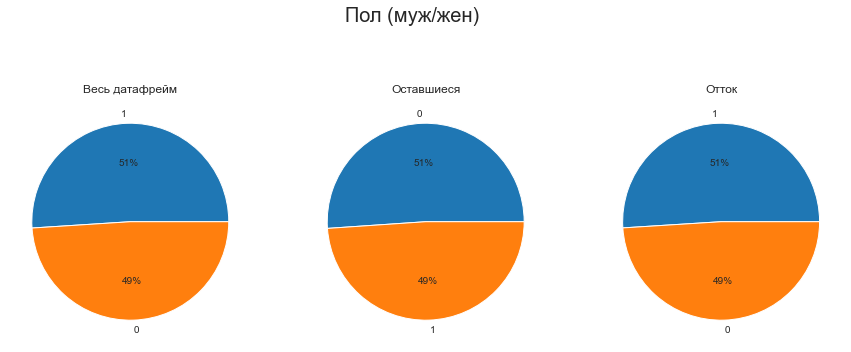

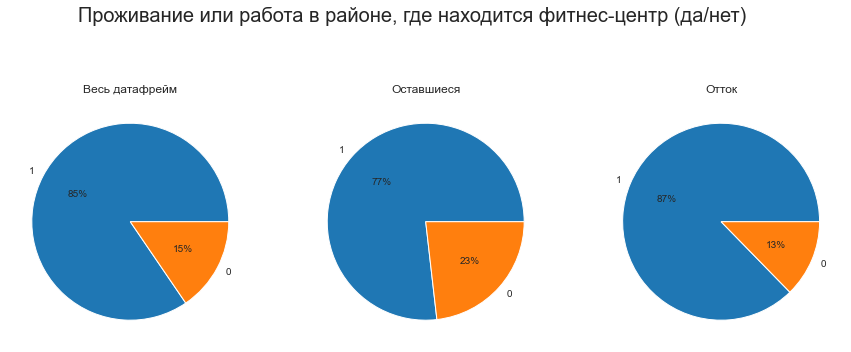

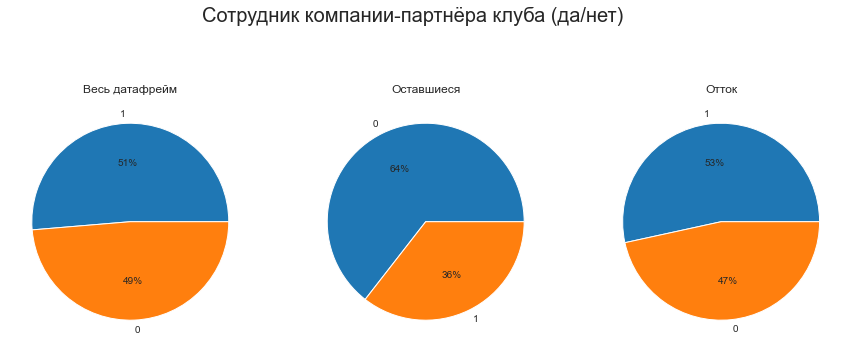

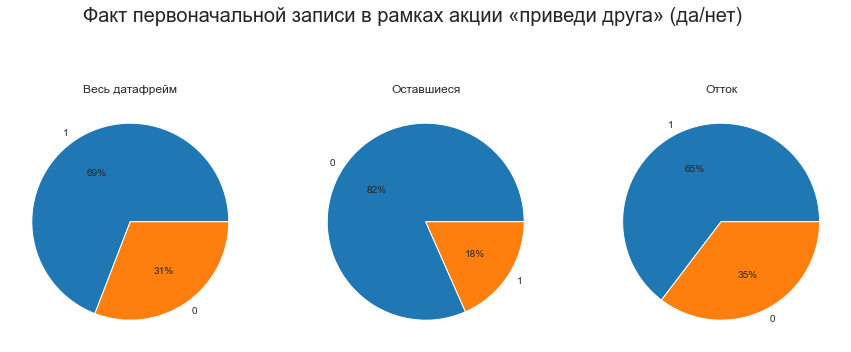

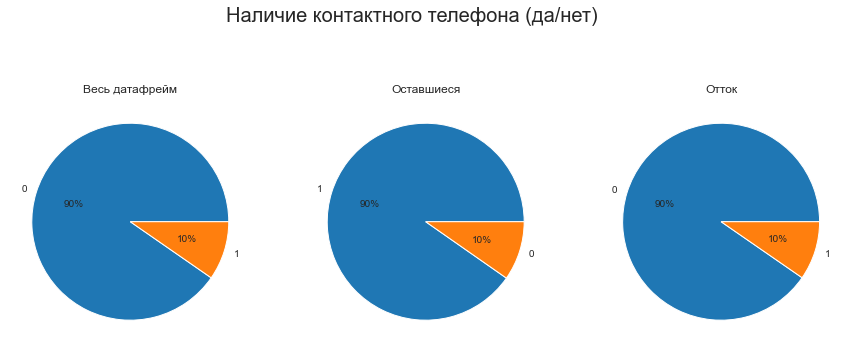

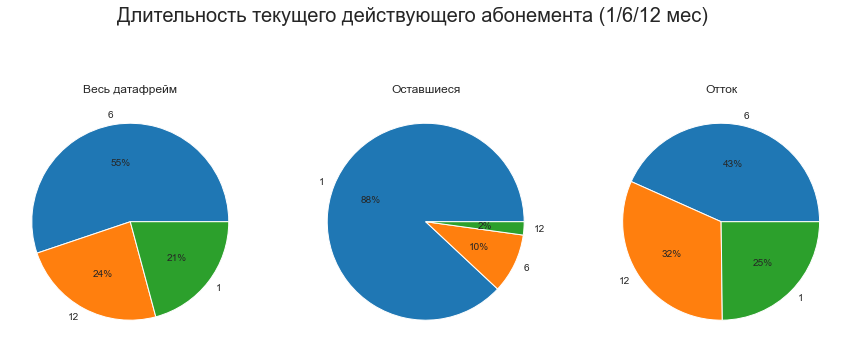

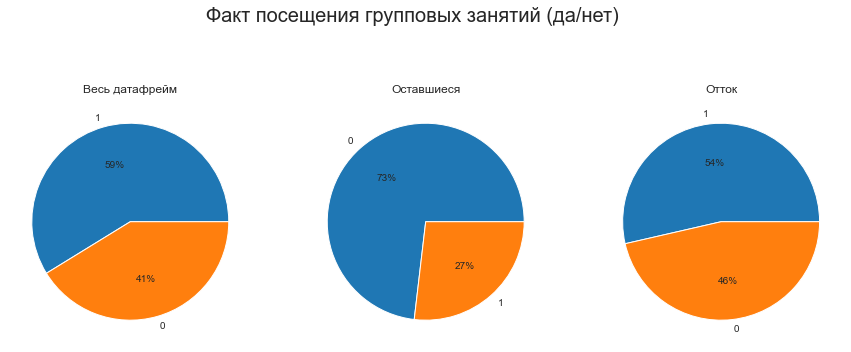

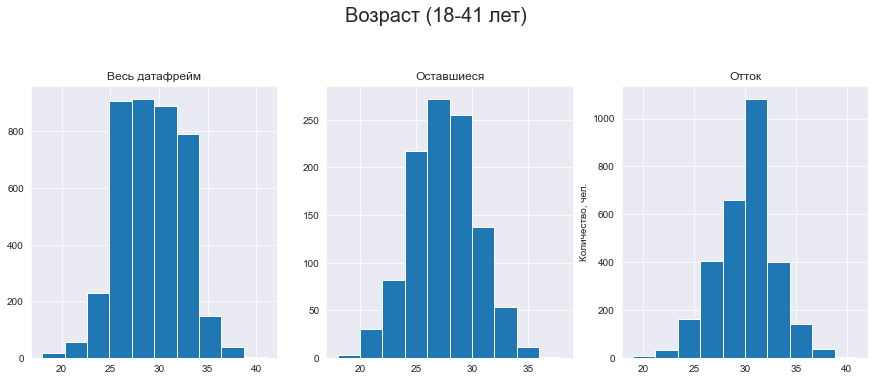

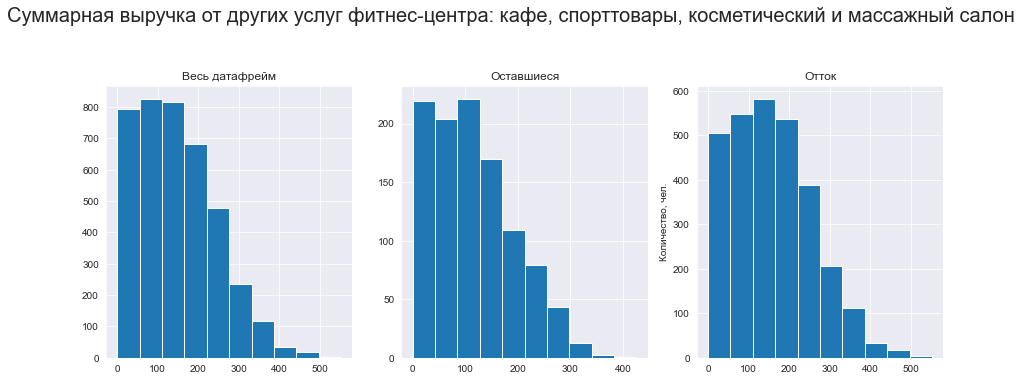

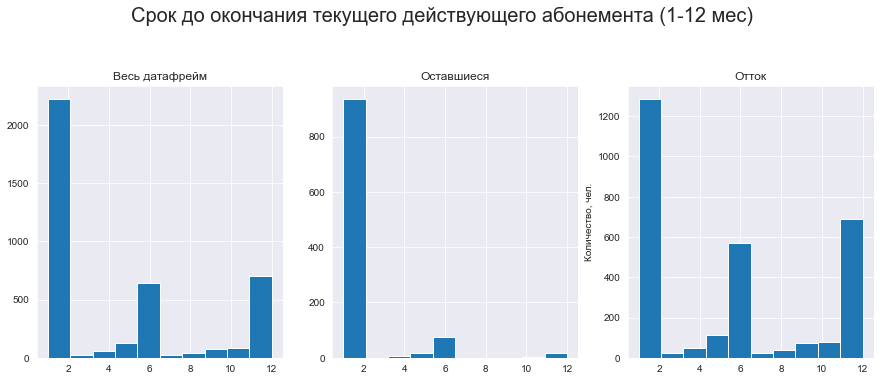

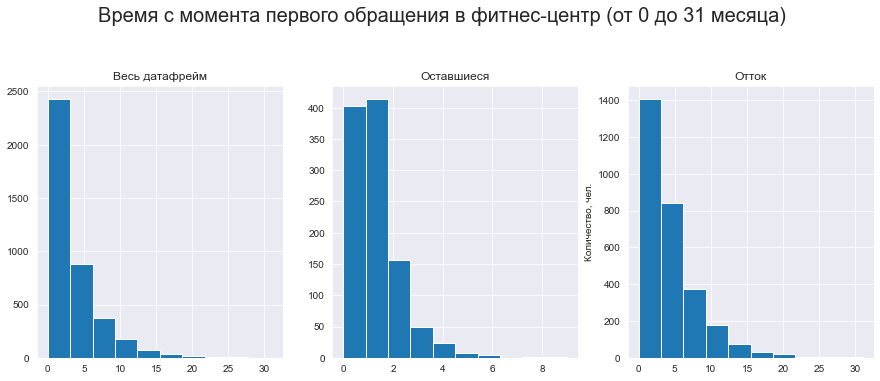

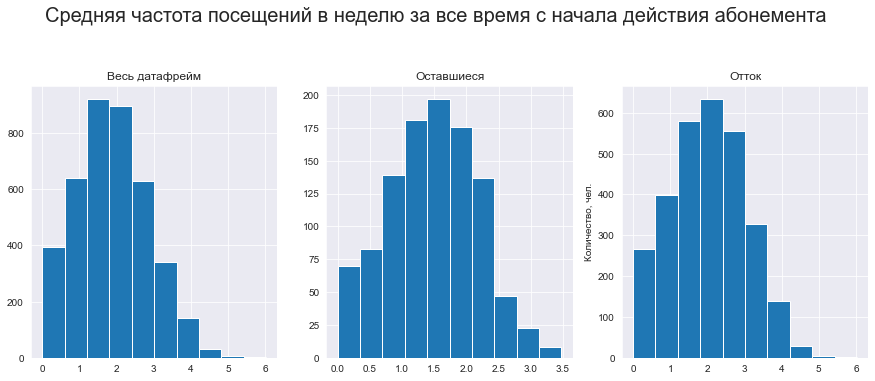

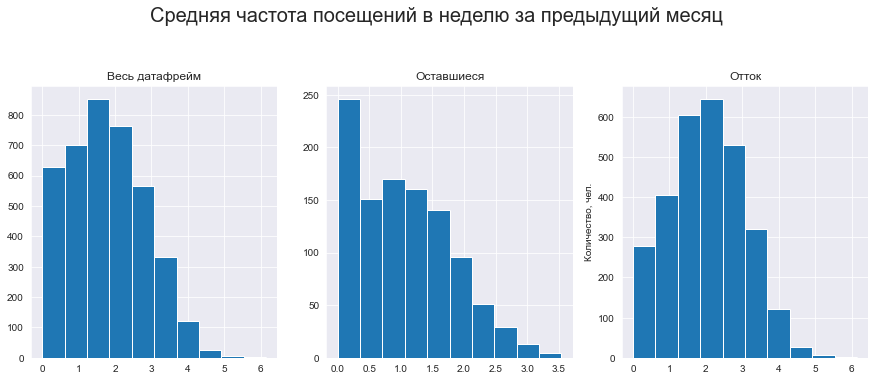

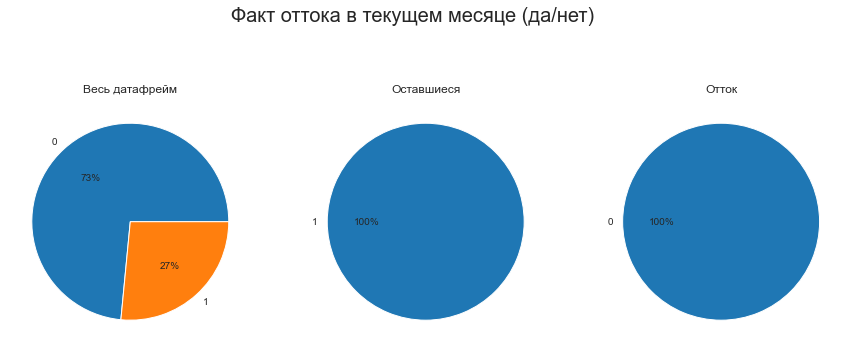

In [16]:
analysis(df, stay, leave)

C:\Users\csvic\AppData\Local\Temp/ipykernel_29516/2316352138.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(dataframe.corr().round(3), dtype=np.bool))


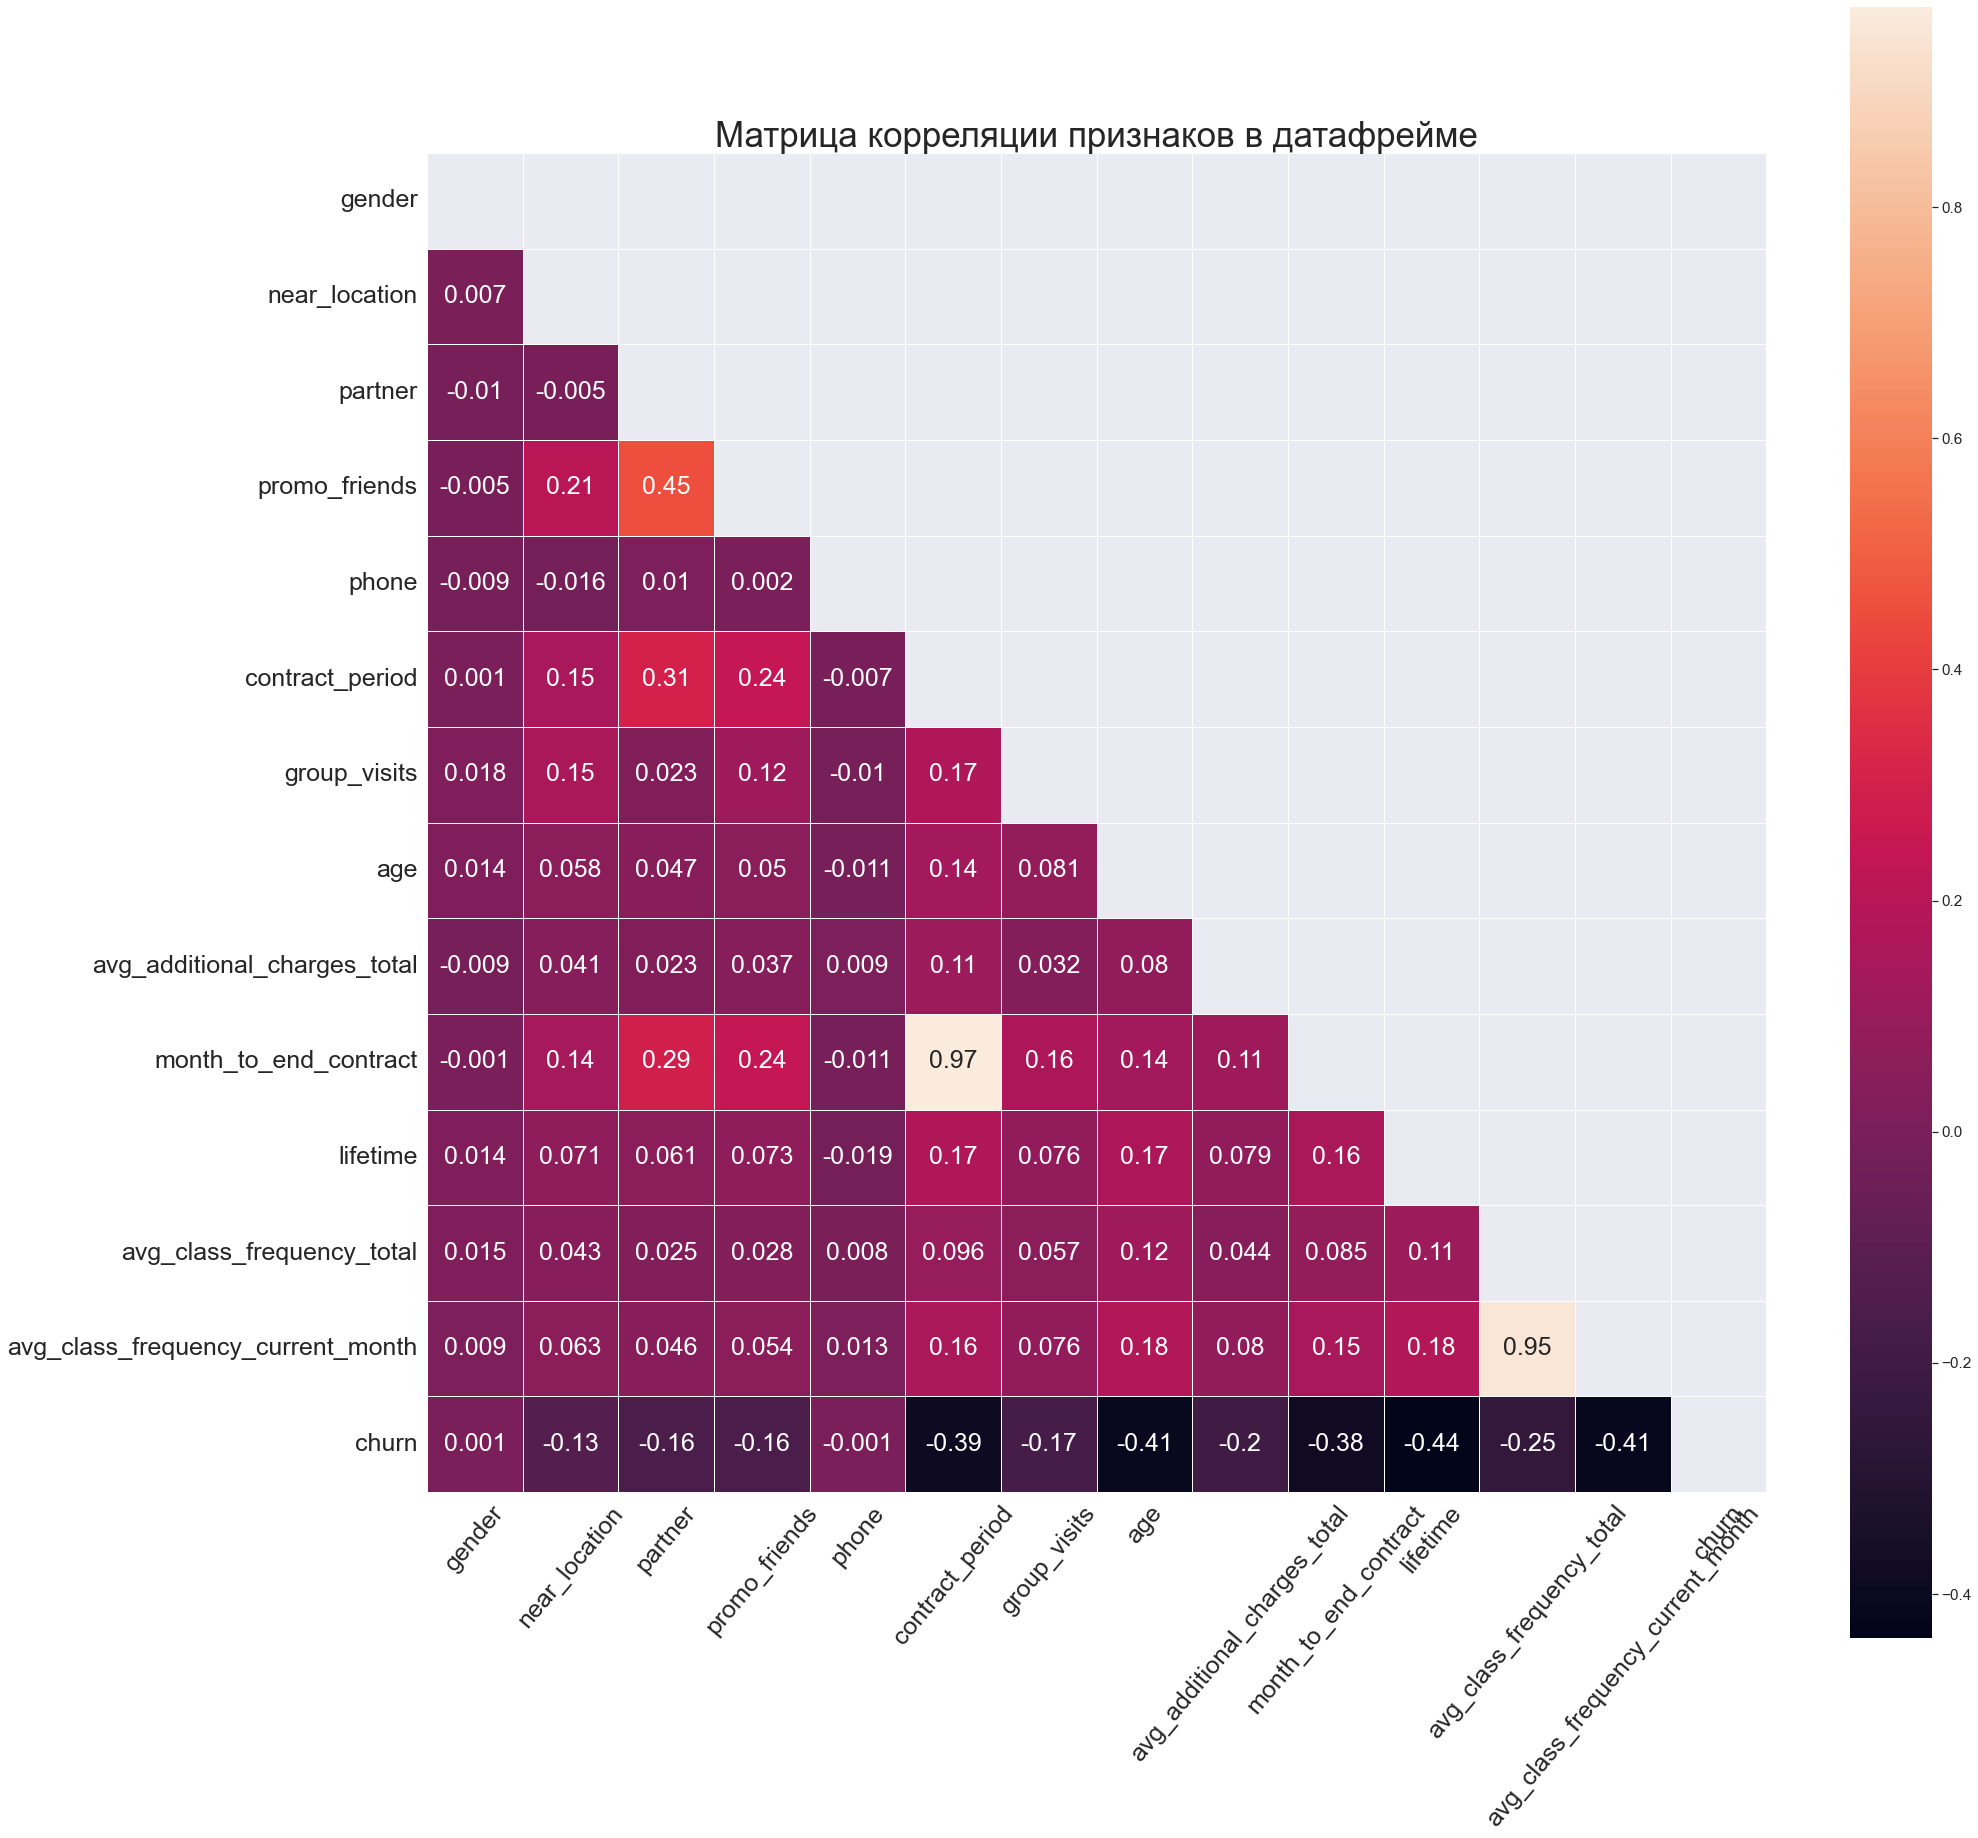

In [17]:
df_corr(df)

C:\Users\csvic\AppData\Local\Temp/ipykernel_29516/2316352138.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(dataframe.corr().round(3), dtype=np.bool))


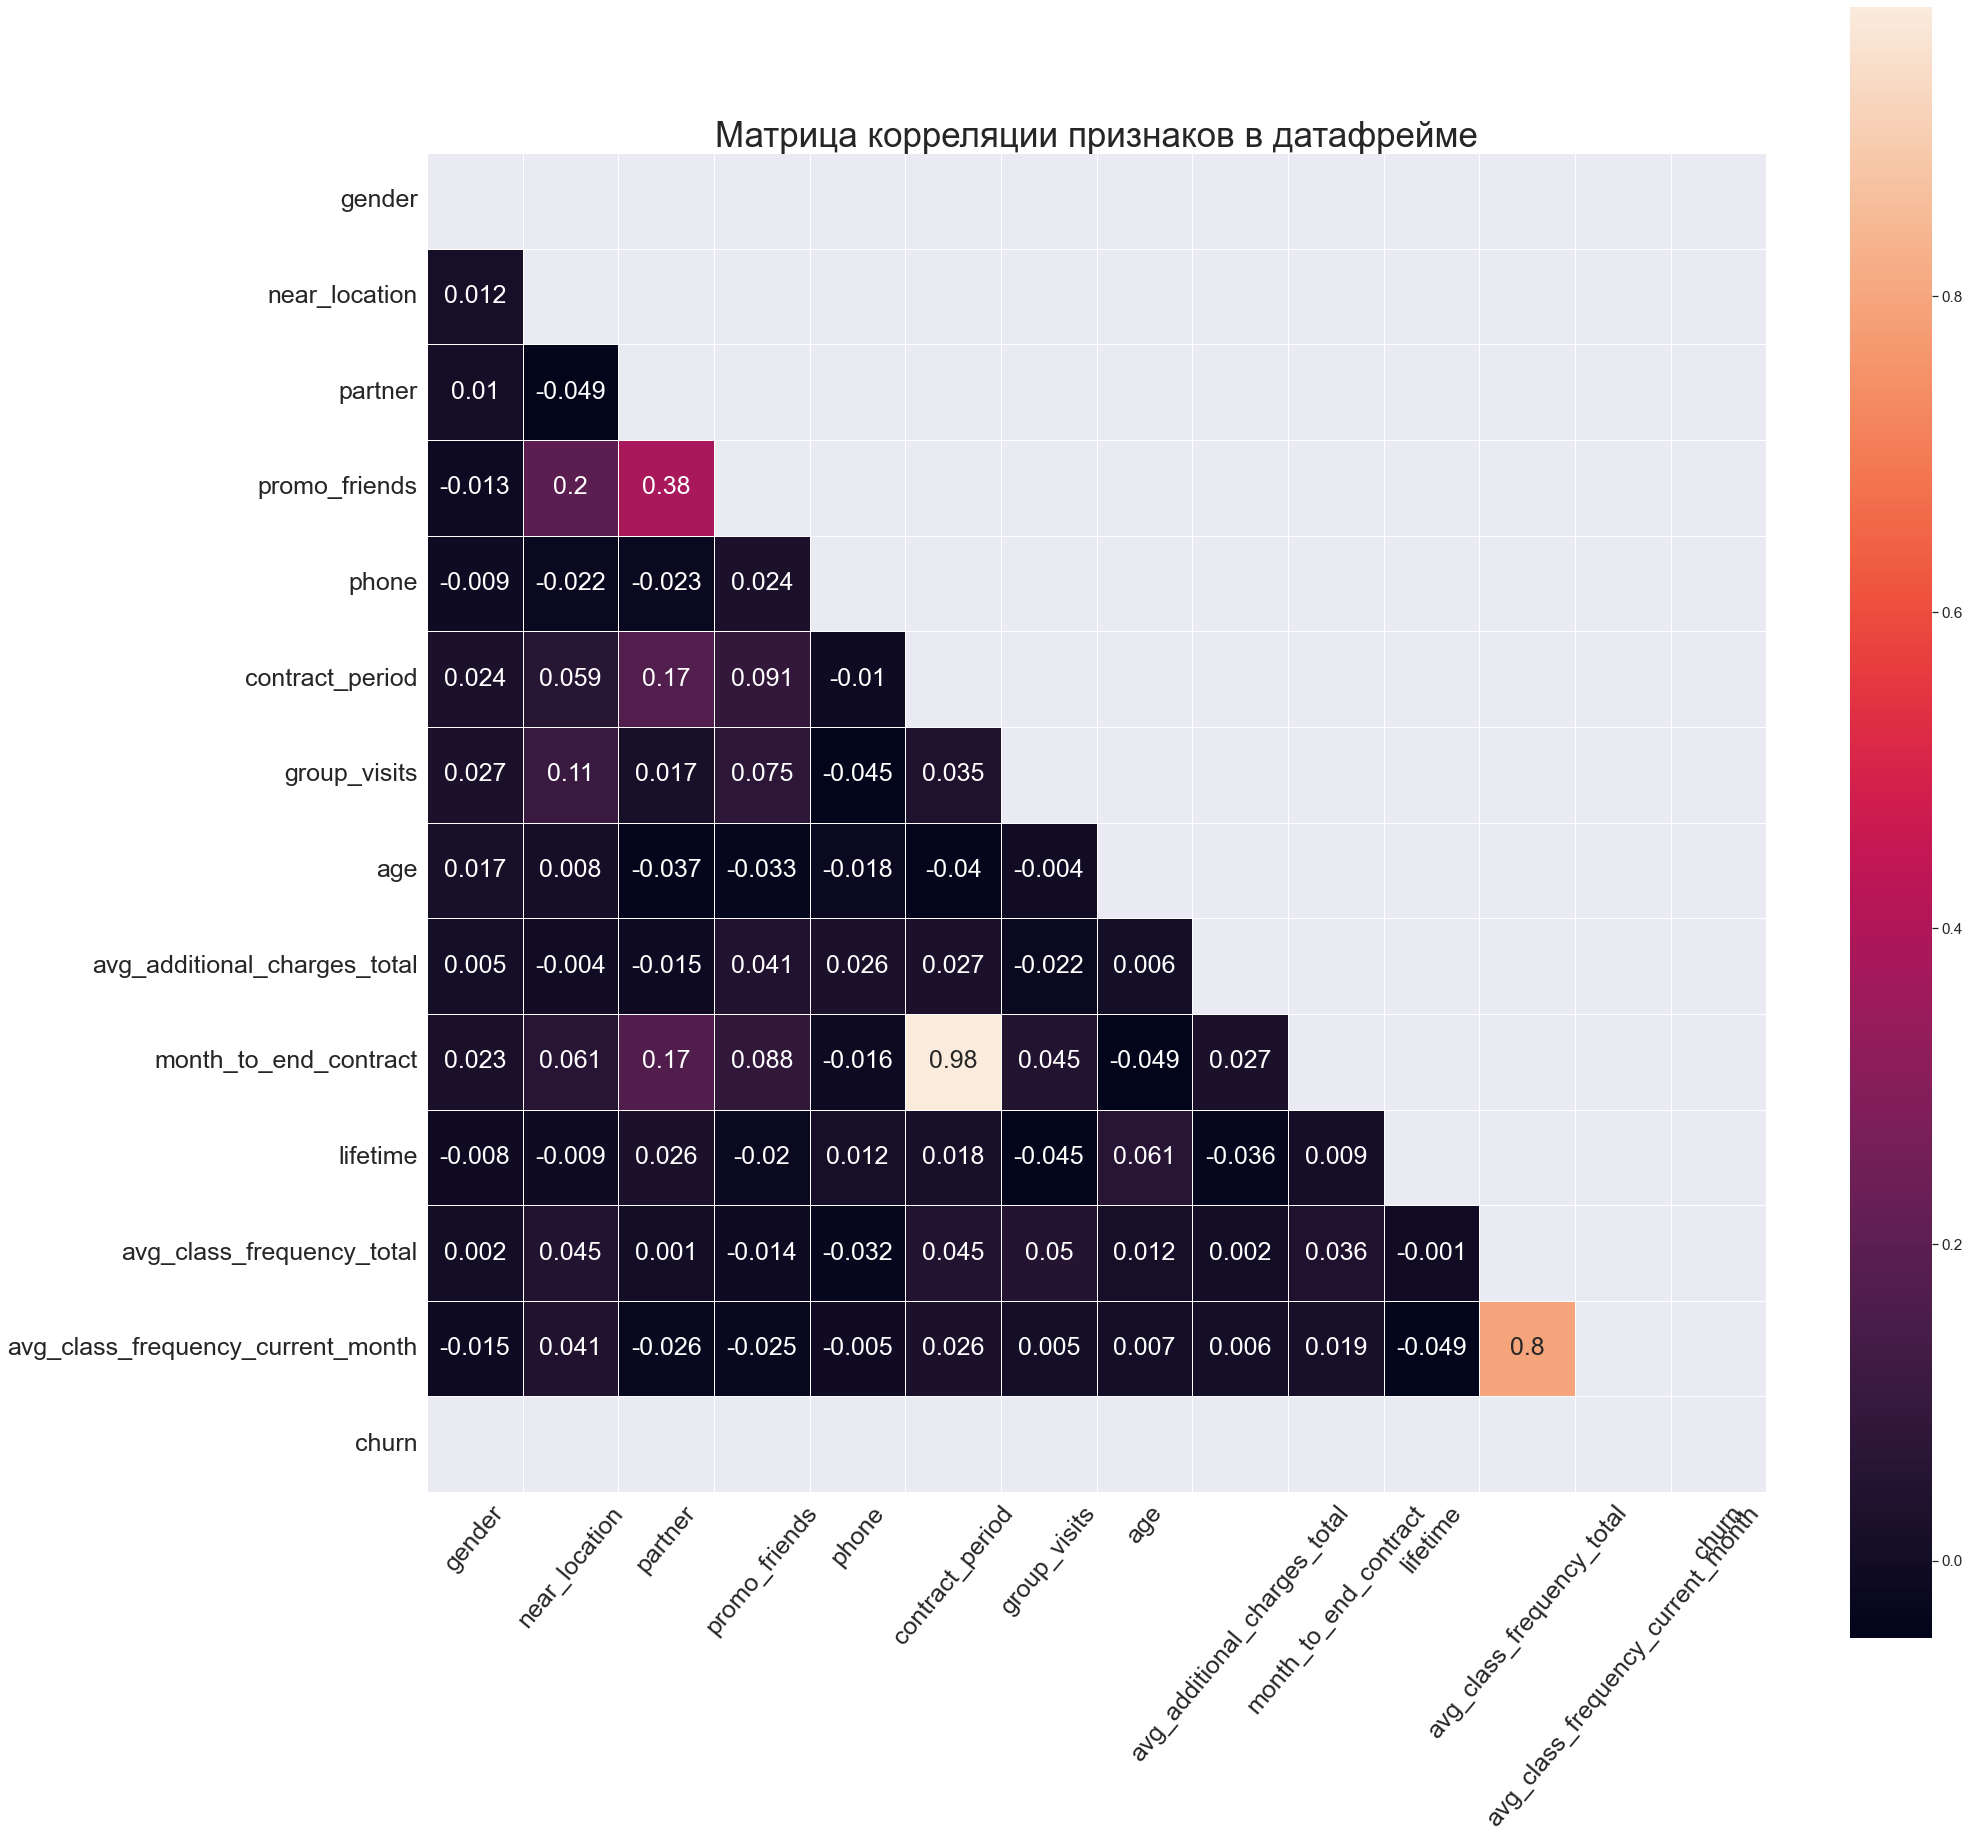

In [18]:
df_corr(stay)

C:\Users\csvic\AppData\Local\Temp/ipykernel_29516/2316352138.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(dataframe.corr().round(3), dtype=np.bool))


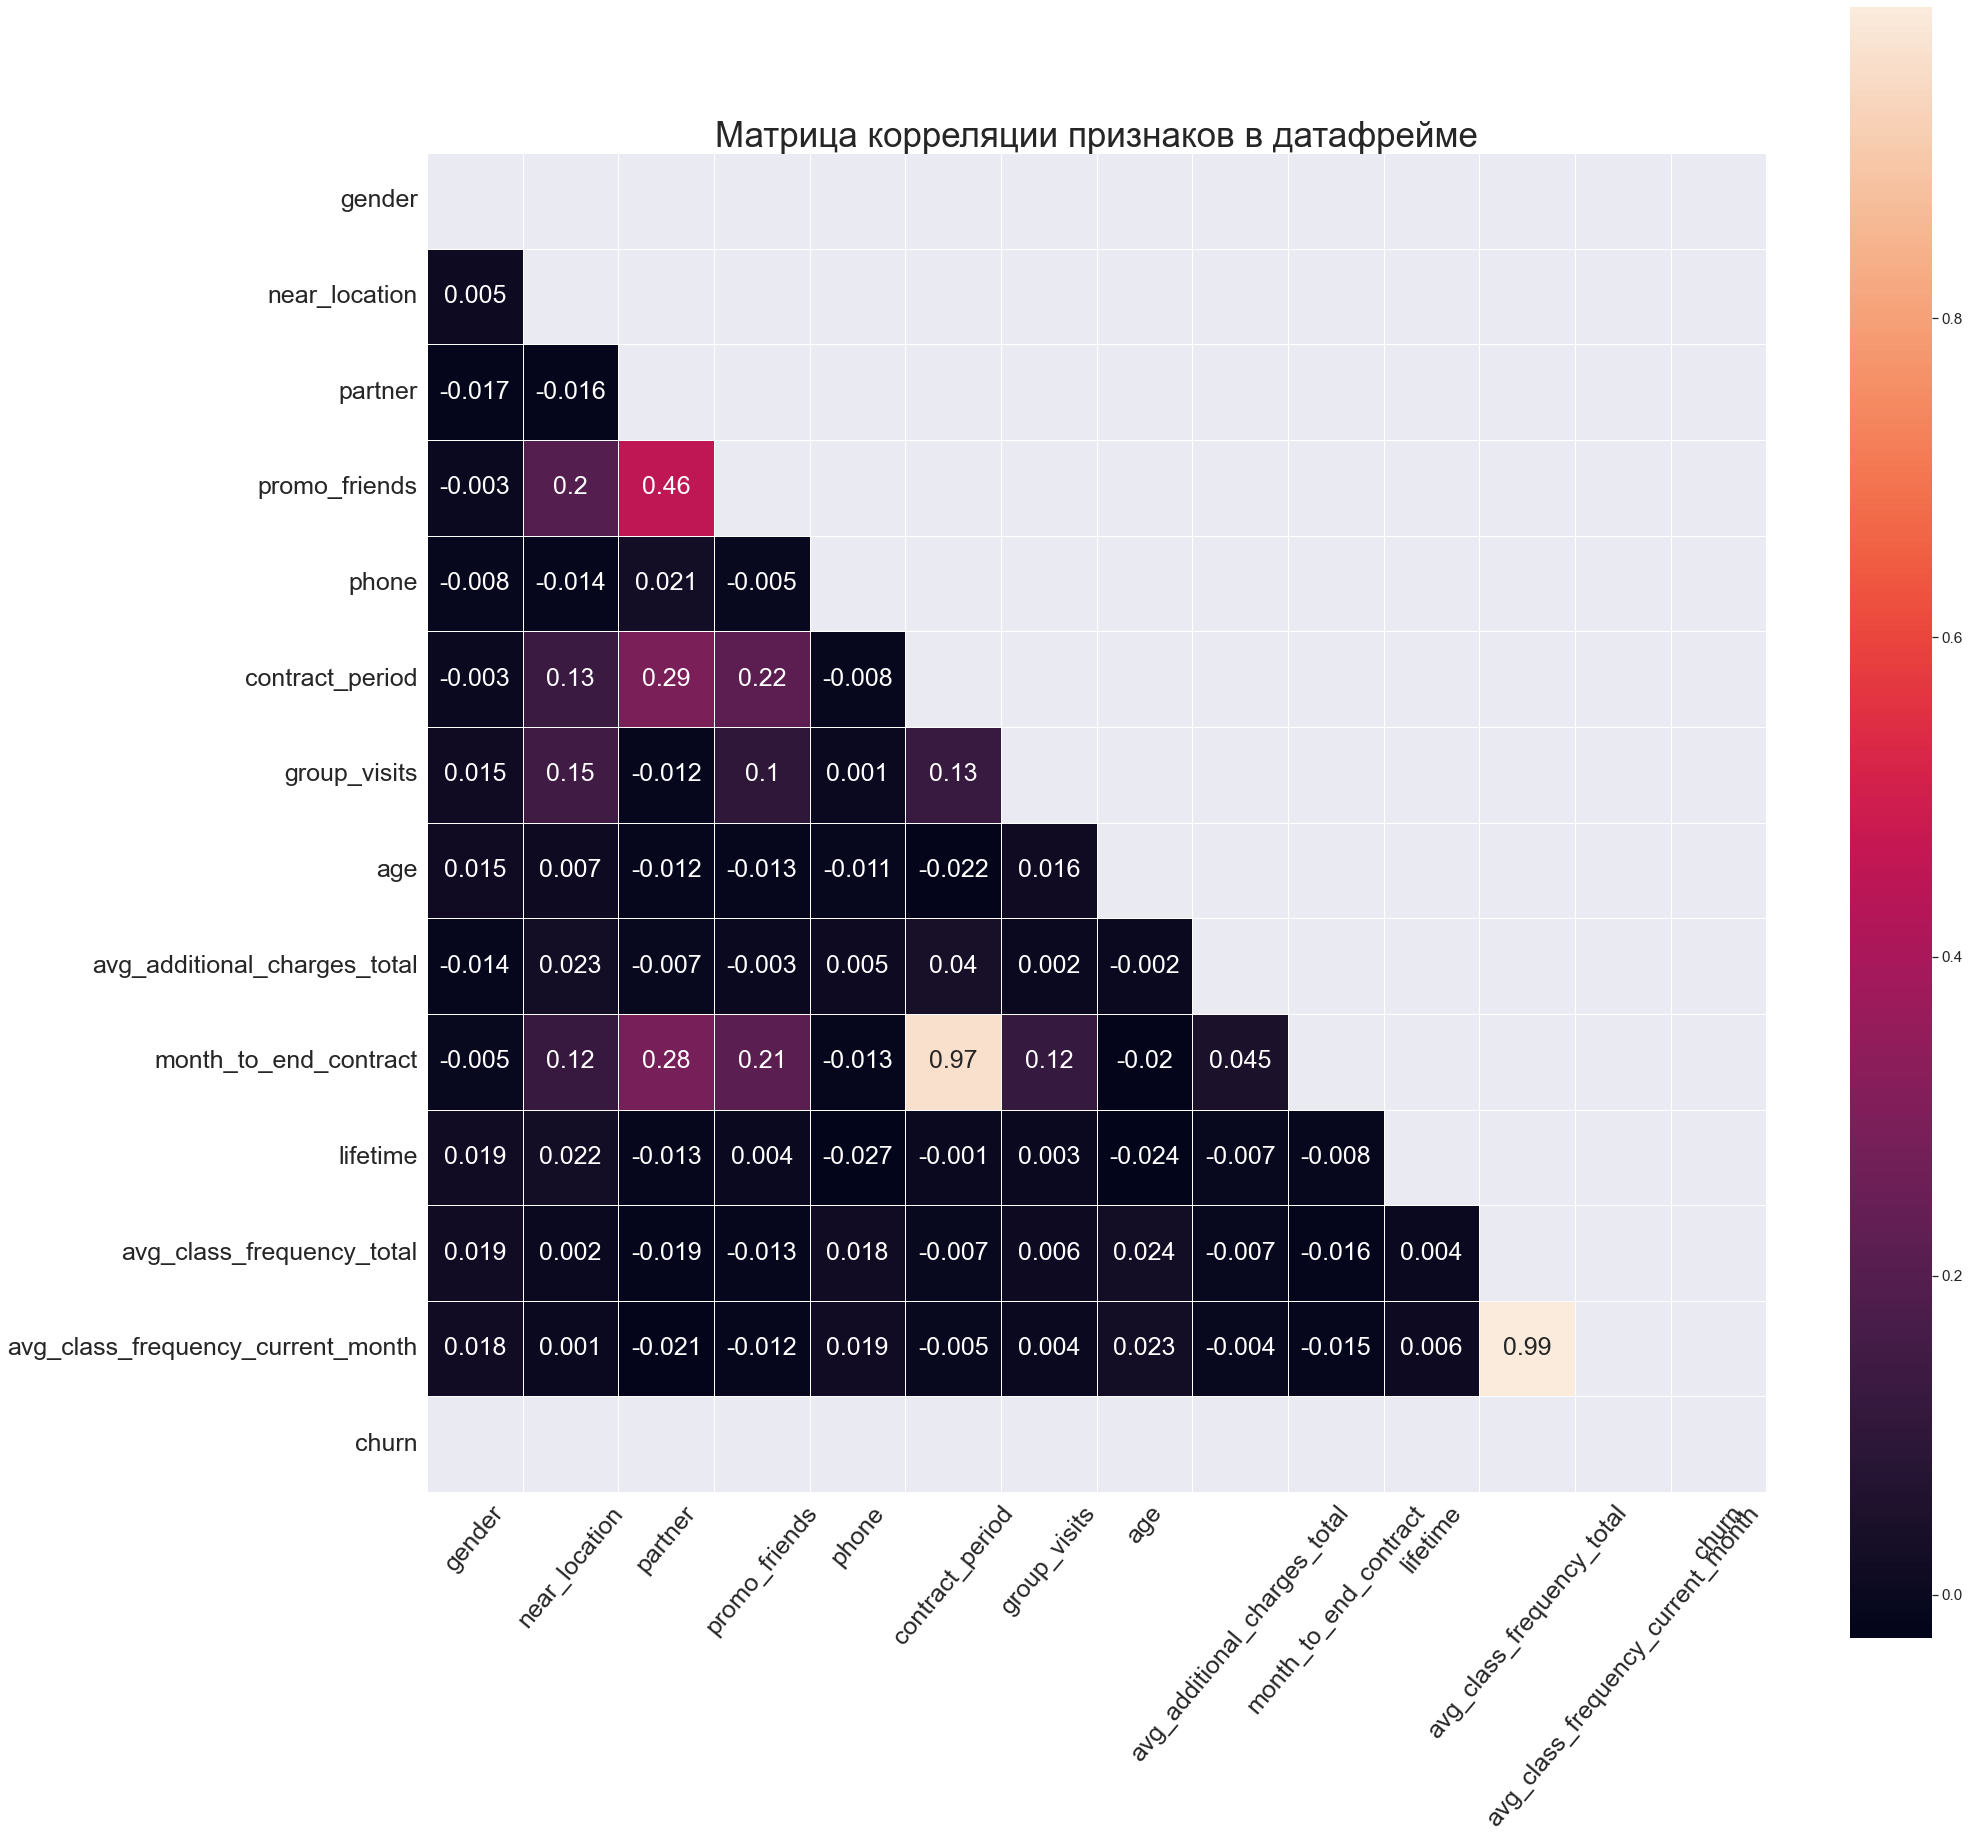

In [19]:
df_corr(leave)

### 3.1 Вывод

Рассмотрим показатели, распределение которых различно для тех, кто остался (73%), и тех, кто ушел (27%):
* Проживание или работа в районе, где находится фитнес-центр. Из оставшихся 77% проживают или работают в районе фитнес-центра, а из оттока 87%.
* Сотрудник компании-партнера. Из оставшихся 64% являются сотрудниками компании-партнера, а из оттока 53%.
* Факт первоначальной записи в рамках акции "приведи друга". Из оставшихся 82% пришли по акции "приведи друга", а из оттока 65%.
* Длительность текущего действующего абонемента (1/6/12 месяцев). Из оставшихся 88% имеют месячный абонемент, 10% 6-мес. абонемент и только 2% 12-мес (среднее значение по признаку 1.7). абонемент. Из оттока 25% имеют месячный абонемент, 43% 6-мес. абонемент и 32% 12-мес. абонемент (среднее значение по признаку 5.7).
* Факт посещения групповых занятий. Из оставшихся 73% посещали групповые занятия, а из оттока 54%.
* Возраст. Средний возраст оставшихся 27 лет, из оттока 30 лет.
* Суммарная выручка от других услуг фитнес-центра. Средняя выручка оставшихся 115, из оттока 158.
* Срок до окончания текущего действующего абонемента (1-12 месяцев). Из оставшихся среднее значение 1.7, а из оттока 5.3.
* Время с момента первого обращения в фитнес-центр (0-31 месяцев). Из оставшихся среднее значение 1, а из оттока 3.9.
* Средняя частота посещений в неделю за все время с начала действия абонемента. Из оставшихся среднее значение 1.5, а из оттока 2.
* Средняя частота посещений в неделю за предыдущий месяц. Из оставшихся среднее значение 1, а из оттока 2.

Корреляция признаков для любой группы (всего датафрейма и для двух групп - оставшиеся и отток):
* Между сроком до окончания текущего действующего абонемента и длительностью текущего абонемента есть очень высокая корреляция.
* Между средней частотой посещений в неделю за предыдущий месяц и за все время есть очень высокая корреляция.

## 4. Модель прогнозирования оттока клиентов <a id="4"></a>

In [20]:
# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = df.drop('churn', axis=1)
y = df['churn']

In [21]:
# разделим модель на обучающую и валидационную выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [22]:
# обучим StandartScaler на обучающей выборке
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [23]:
# преобразуем обучающий и валидационные наборы данных
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

In [24]:
# функцию для метрик
def metrics(y_true, y_pred, y_proba, title='Метрики классификации'):
    print(title)
    print('\tAccuracy (доля правильных ответов): {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision (точность): {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall (полнота): {:.2f}'.format(recall_score(y_true, y_pred)))
    print('\tF1 (баланс между метриками precision и recall): {:.2f}'.format(f1_score(y_true, y_pred)))

### 4.1 Логистическая регрессия <a id="4.1"></a>

In [25]:
# зададим алгоритм для модели логистической регрессии и обучим ее
lr_model = LogisticRegression(random_state=0)
lr_model.fit(X_train_st, y_train)

LogisticRegression(random_state=0)

In [26]:
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:, 1]

In [27]:
metrics(y_test, lr_predictions, lr_probabilities, title='Метрики для модели логистической регрессии:')

Метрики для модели логистической регрессии:
	Accuracy (доля правильных ответов): 0.94
	Precision (точность): 0.90
	Recall (полнота): 0.85
	F1 (баланс между метриками precision и recall): 0.87


### 4.2 Случайный лес <a id="4.2"></a>

In [28]:
# зададим алгоритм для новой модели на основе алгоритма случайного леса и обучим модель
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [29]:
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
rf_predictions = rf_model.predict(X_test)
rf_probabilities = rf_model.predict_proba(X_test)[:, 1]

In [30]:
metrics(y_test, rf_predictions, rf_probabilities, title='Метрики для модели случайного леса:')

Метрики для модели случайного леса:
	Accuracy (доля правильных ответов): 0.92
	Precision (точность): 0.88
	Recall (полнота): 0.83
	F1 (баланс между метриками precision и recall): 0.85


### 4.3 Вывод

У модели логической регрессии все показатели (доля правильных ответов, точность и полнота) лучше, чем у модели случайного леса.

## 5. Кластеризация клиентов <a id="5"></a>

In [31]:
# стандартизируем данные
X_sc = scaler.fit_transform(X)

### 5.1 Матрица расстояний <a id="5.1"></a>

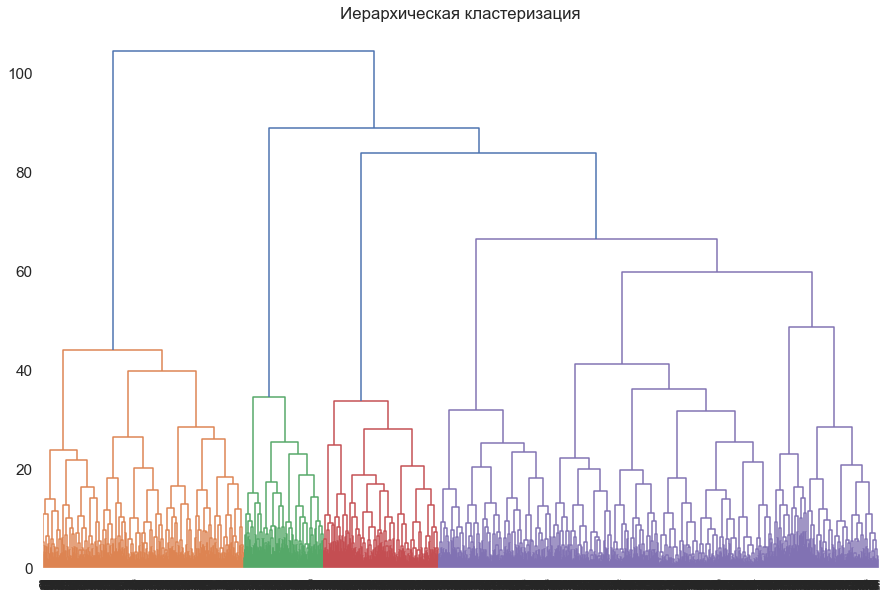

In [32]:
# построим матрицу расстояний и визуализируем ее как дендрограмму
linked = linkage(X_sc, method='ward')
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация')
plt.show()

#### 5.1.1 Вывод

Согласно матрице расстояний и дендрограмме клиентов можно разделить на 4 кластера.

### 5.2 Алгоритм K-Means <a id="5.2"></a>

Несмотря на результаты кластеризации по матрице расстояний, решили задать для K-Means 5 кластеров.

In [33]:
# задаем 5 кластеров
km = KMeans(n_clusters=5, random_state=0)

In [34]:
# применим алгоритм к данным и сформируем вектор кластеров
labels = km.fit_predict(X_sc)

In [35]:
# добавим распределение по кластерам в датафрейм
df['cluster_km'] = labels

In [36]:
# статистика по средним значениям признаков по кластеру
df.groupby(['cluster_km']).mean().T

cluster_km,0,1,2,3,4
gender,0.502970,0.522078,0.495050,0.485737,0.559666
near_location,0.959406,0.862338,0.000000,1.000000,0.976134
partner,0.783168,0.470130,0.463366,0.350238,0.356802
promo_friends,0.574257,0.306494,0.079208,0.240095,0.230310
phone,1.000000,0.000000,1.000000,1.000000,0.998807
contract_period,10.889109,4.787013,2.352475,1.948494,2.669451
group_visits,0.542574,0.425974,0.215842,0.341521,0.473747
age,29.982178,29.301299,28.477228,28.167987,30.125298
avg_additional_charges_total,160.761016,143.957664,135.457501,131.622204,161.657905
month_to_end_contract,9.954455,4.475325,2.198020,1.856577,2.459427


In [37]:
# статистика по оттоку по кластерам
cluster_churn = df.pivot_table(index='cluster_km', columns='churn', values='gender', aggfunc='sum', margins=True)
cluster_churn.columns = ['leave', 'stay', 'all, %']
cluster_churn['leave, %'] = (cluster_churn['leave'] / cluster_churn['all, %'] * 100).round(1)
cluster_churn['stay, %'] = (cluster_churn['stay'] / cluster_churn['all, %'] * 100).round(1)
cluster_churn['all, %'] = (cluster_churn['all, %'] / 2041 * 100).round(1)
cluster_churn

,leave,stay,"all, %","leave, %","stay, %"
cluster_km,,,,,
0,491,17,24.9,96.7,3.3
1,147,54,9.8,73.1,26.9
2,138,112,12.2,55.2,44.8
3,286,327,30.0,46.7,53.3
4,437,32,23.0,93.2,6.8
All,1499,542,100.0,73.4,26.6


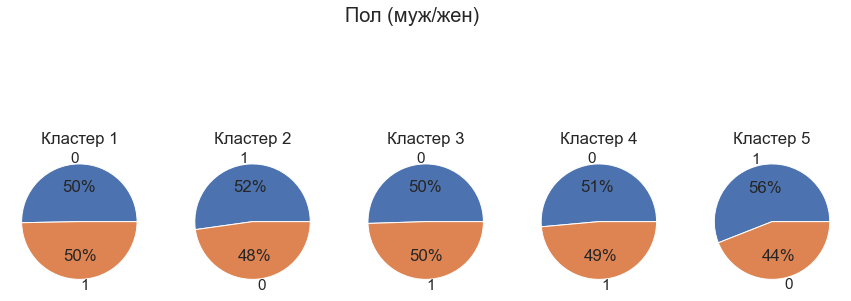

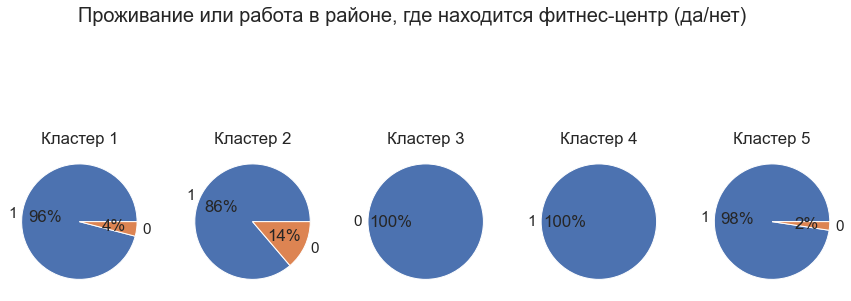

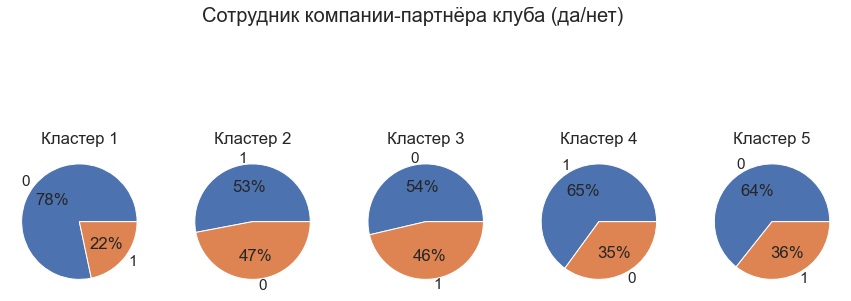

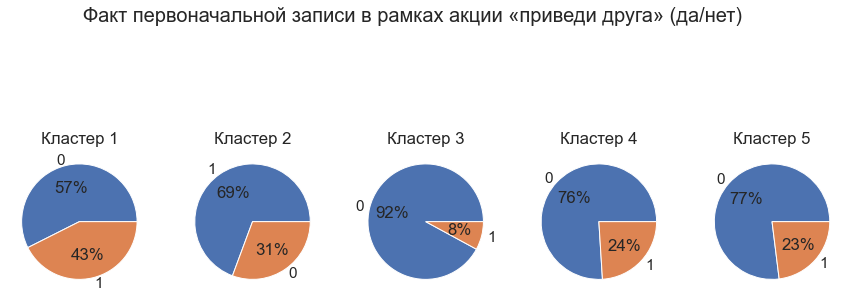

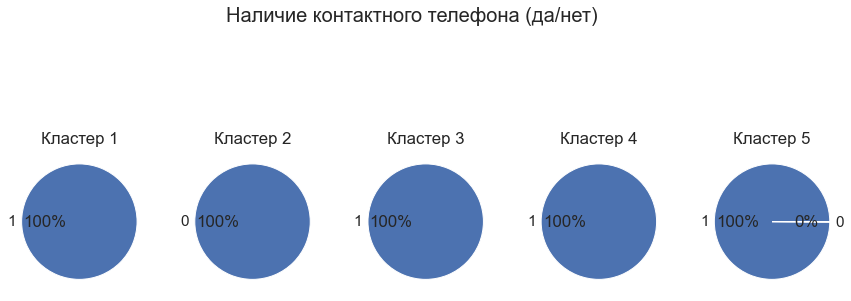

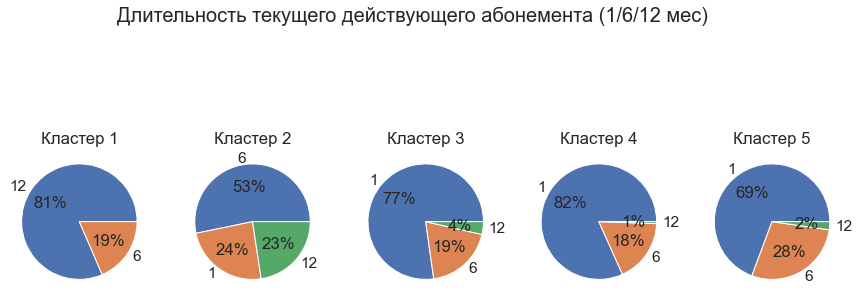

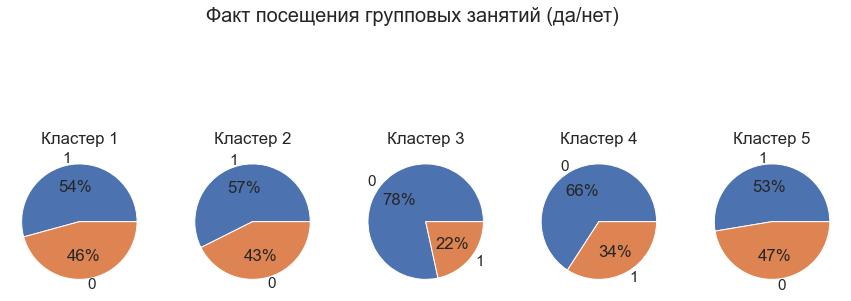

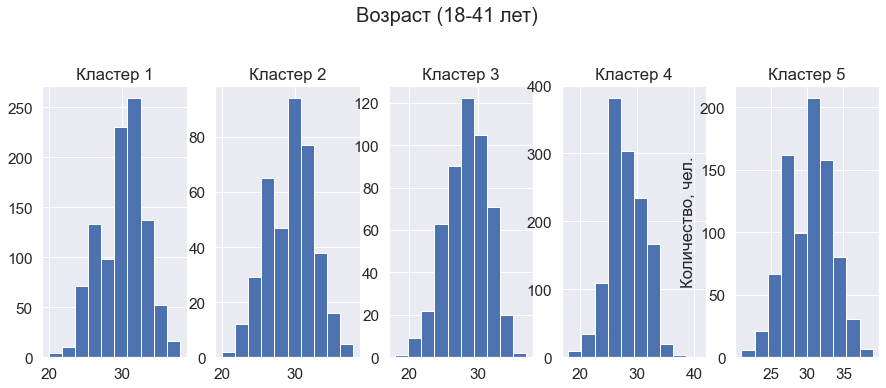

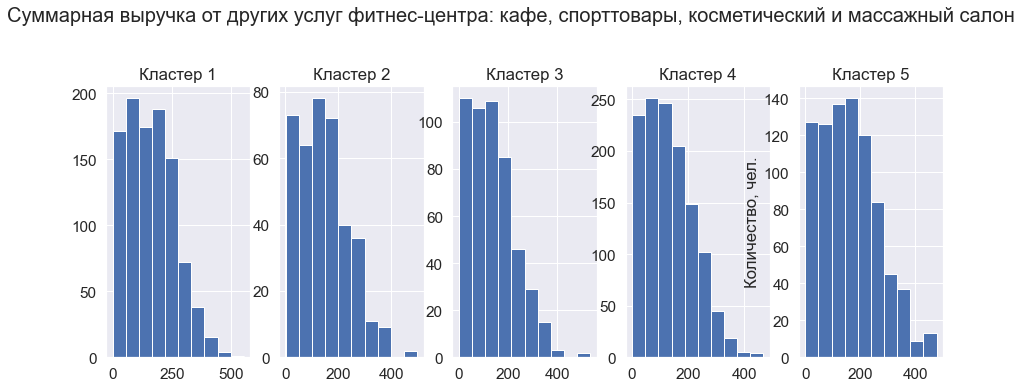

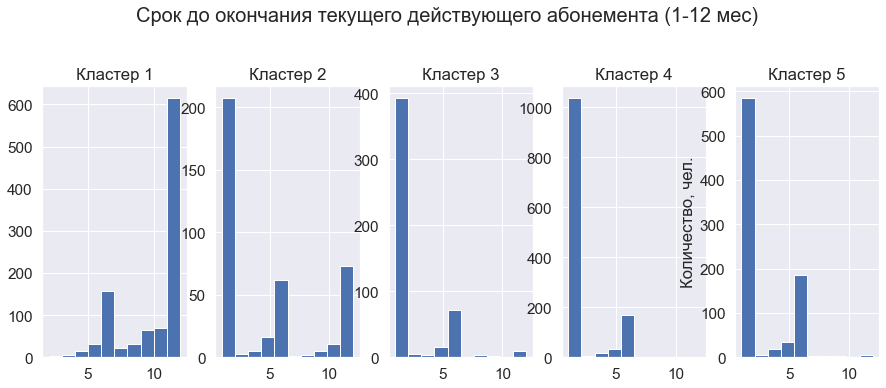

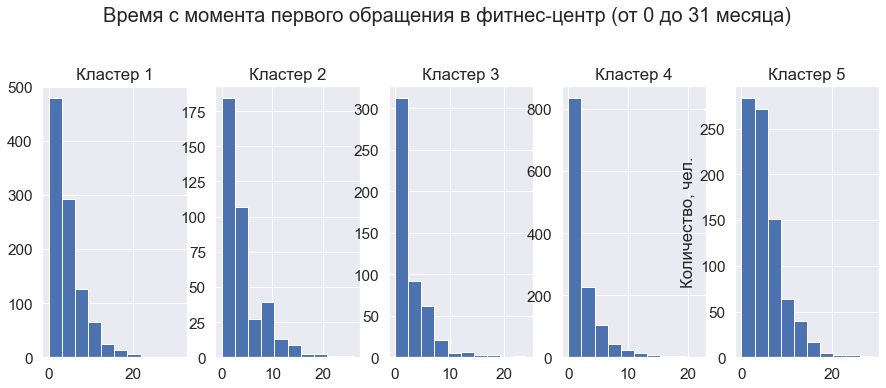

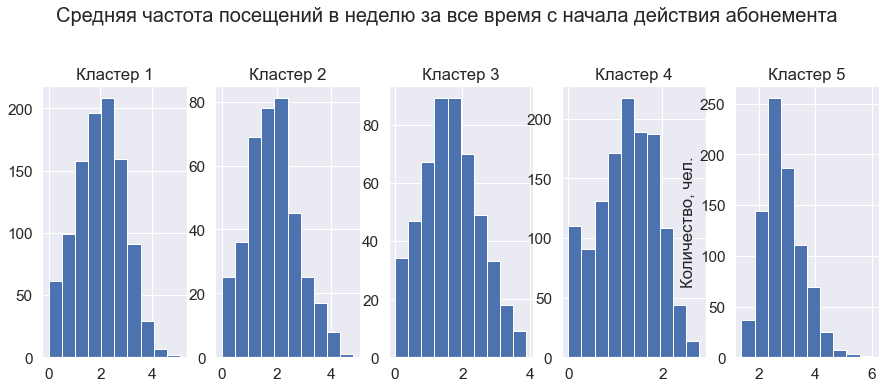

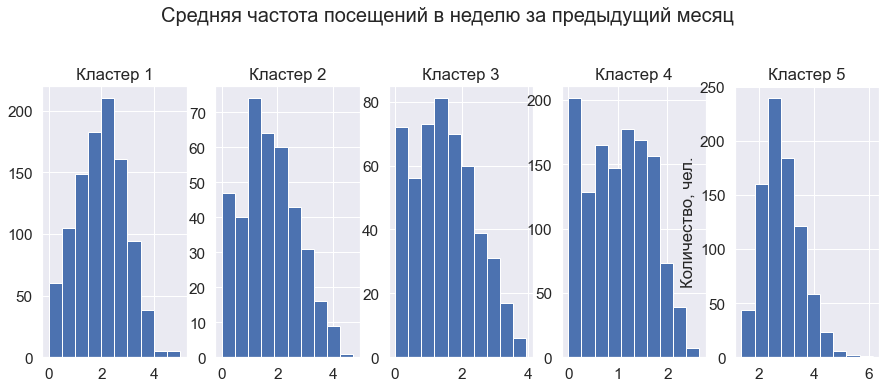

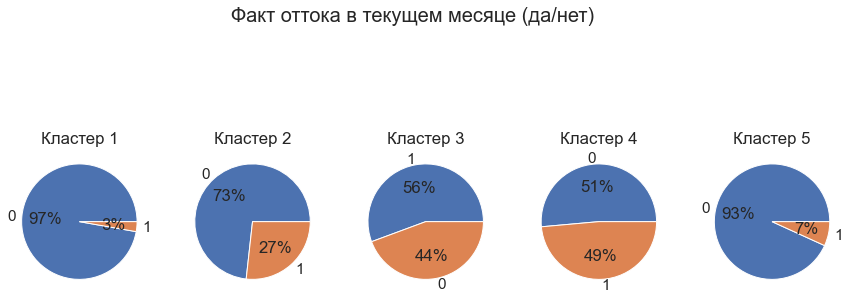

In [38]:
km_analysis(df)

#### 5.2.1 Вывод

По результатам деления клиентов на 5 кластеров.

Наиболее надежные кластеры:
1. **1 кластер — 25% от всей выборки. 97% оставшихся. Портрет клиента:**
* Живет или работает в районе, где находится фитнес-центр.
* НЕ являются сотрудники компании-партнёра клуба.
* Долго думает о покупке абонемента. После первого обращения в фитнес центр купил абонемент только спустя 3 месяца. Покупает сразу абонемент на год.
* Уже пару месяцев ходит в фитнес-центр и тратит деньги на другие услуги (161). В среднем посещают фитнес-центр 2 раза в неделю.
* Средний возраст 30 лет.

2. **5 кластер — 23% от всей выборки. 93% оставшихся. Портрет клиента:**
* Живет или работает в районе, где находится фитнес-центр.
* Скорее всего сразу при обращении в фитнес-центр купит абонемент на 1 мес.
* Тратит деньги на другие услуги (162). В среднем посещают фитнес-центр 3 раза в неделю.
* Средний возраст 30 лет.

3. **2 кластер — 10% от всей выборки. 73% оставшихся. Портрет клиента:**
* Живет или работает в районе, где находится фитнес-центр.
* Не оставляет номер контактного телефона.
* Обращаются в фитнес-центр и сразу покупают абонемент на 6 мес.
* Средний возраст 29 лет.
* Тратит деньги на другие услуги (144). В среднем посещают фитнес-центр 2 раза в неделю.

Кластеры, склонные к оттоку:
1. **3 кластер — 12% от всей выборки. 45% уходят. Портрет клиента:**
* Клиент НЕ проживает и НЕ работает в районе, где находится фитнес-центр.
* Пришел не по рекомендации (НЕ по акции «приведи друга»).
* Купит абонемент на 1 мес.
* Сначала ходит 2 раза в неделю, потом посещение снижается до 1 раза в неделю. Групповые занятия не посещает.
* Средний возраст 28 лет.

2. **4 кластер — 30% от всей выборки. 53% уходят. Портрет клиента:**
* Клиент живет или работает в районе, где находится фитнес-центр и скорее всего является сотрудником компании-партнёра.
* Купит абонемент на 1 мес.
* Ходит в фитнес-центр 1 раз в неделю. Групповые занятия скорее всего не посещает.
* Средний возраст 28 лет.

## 7. Выводы и базовые рекомендации по работе с клиентами <a id="7"></a>

Для машинного обучения использовать **модель логической регрессии*.

**Признаки, которые влияют на отток:**
* Длительность текущего действующего абонемента.
* Время с момента первого обращения в фитнес-центр.
* Факт посещения групповых занятий.
* Суммарная выручка от других услуг фитнес-центра

**Типичные портреты клиентов (выделить несколько наиболее ярких групп и охарактеризовать их основные свойства.):**
1. Клиент живет или работает в районе, где находится фитнес-центр и НЕ является сотрудником компании-партнёра клуба. Долго думает о покупке абонемента, через месяца 3 решает купить абонемент сразу на год. Тратит деньги на другие услуги. В среднем посещают фитнес-центр 2 раза в неделю. Средний возраст 30 лет.
2. Клиент живет или работает в районе, где находится фитнес-центр. Сразу при обращении в фитнес-центр покупает абонемент на 1 мес. Тратит деньги на другие услуги. В среднем посещают фитнес-центр 3 раза в неделю. Средний возраст 30 лет.
3. Клиент НЕ проживает и НЕ работает в районе, где находится фитнес-центр. Пришел не по рекомендации (НЕ по акции «приведи друга»). Купит абонемент на 1 мес. Групповые занятия не посещает. Сначала будет ходить 2 раза в неделю, потом 1 раз в неделю, потом бросит заниматься совсем. Средний возраст 28 лет.
4. Клиент живет или работает в районе, где находится фитнес-центр и скорее всего является сотрудником компании-партнёра. Купит абонемент на 1 мес. Групповые занятия скорее всего не посещает. Ходит в фитнес-центр 1 раз в неделю. И по окончании абонемента перестает посещать фитнес-клуб. Средний возраст 28 лет.

**Рекомендации для стратегии взаимодействия с клиентами и их удержания. предложить меры по снижению оттока**
1. Половина из тех, кто живет/работает в районе клуба и пришел от компании-партнера, скорее всего походят только 1 месяц и уйдут. Можно попробовать предложить им лучшие условия на 6 и 12 мес абонементы. Вероятно, они все равно будут ходить 1 месяц, зато это разово позволит повысить выручку в компании.
2. Те, кто не живут/работают в районе фитнес-клуба с большой вероятностью не будут постоянными клиентами, поэтому можно снизить маркетинговые расходы на данную категорию потенциальных клиентов.
3. Клиенты, которые берут абонементы сразу на 12 месяцев, скорее всего долго над этим думают и лояльны фитнес-центру. Им можно предложить специальные условия на "приведи друга".
4. Предлагать скидку клиентам на последующую покупку абонементов, которые живут/работают в районе фитнес-центра, у которых абонемент на 1 месяц и они посещают фитнес-центр 3 раза в неделю.
5. Посетители групповых занятий реже уходят из клуба, поэтому стоит продумать связанные с ними акционные предложения.